In [ ]:

# Inpired / modified from code in : https://github.com/huggingface/diffusers/tree/main/examples

%%capture
!pip install diffusers[training]==0.11.1

In [ ]:
from huggingface_hub import notebook_login

notebook_login()


Then you need to install Git-LFS to upload your model checkpoints:

In [ ]:
%%capture
!sudo apt -qq install git
!git config --global credential.helper store

In [ ]:
from dataclasses import dataclass

@dataclass
class TrainingConfig:
    image_size = 128  # the generated image resolution
    train_batch_size = 16
    eval_batch_size = 16  # how many images to sample during evaluation
    num_epochs = 50
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 10
    save_model_epochs = 30
    mixed_precision = 'fp16'  # `no` for float32, `fp16` for automatic mixed precision
    output_dir = 'pharma_protease_test'  # the model namy locally and on the HF Hub

    push_to_hub = True  # whether to upload the saved model to the HF Hub
    hub_private_repo = False
    overwrite_output_dir = True  # overwrite the old model when re-running the notebook
    seed = 0

config = TrainingConfig()

In [ ]:
from datasets import load_dataset

#config.dataset_name = "huggan/smithsonian_butterflies_subset"
#dataset = load_dataset(config.dataset_name, split="train")

# Feel free to try other datasets from https://hf.co/huggan/ too!
# Here's is a dataset of flower photos:
# config.dataset_name = "huggan/flowers-102-categories"
# dataset = load_dataset(config.dataset_name, split="train")

# Or just load images from a local folder!
config.dataset_name = "imagefolder"
dataset = load_dataset(config.dataset_name, data_dir="/content/test")

Resolving data files:   0%|          | 0/43 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
dataset
dataset = dataset['train']

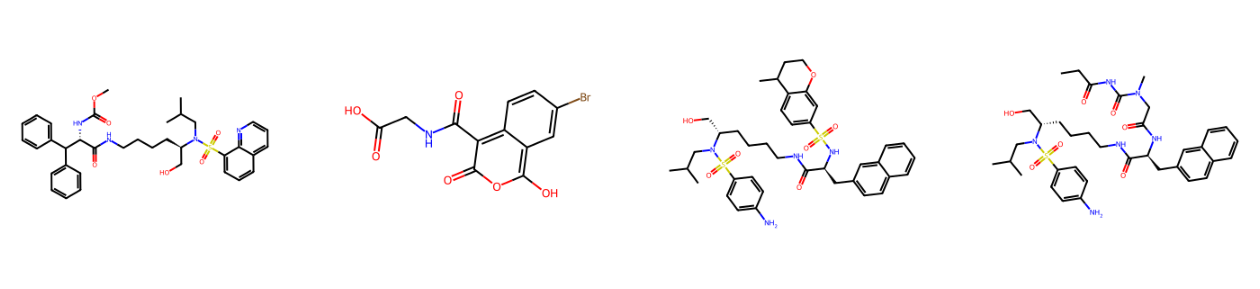

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(dataset[:4]["image"]):
    axs[i].imshow(image)
    axs[i].set_axis_off()
fig.show()

In [ ]:
from torchvision import transforms

preprocess = transforms.Compose(
    [
        transforms.Resize((config.image_size, config.image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

In [ ]:
def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}

dataset.set_transform(transform)

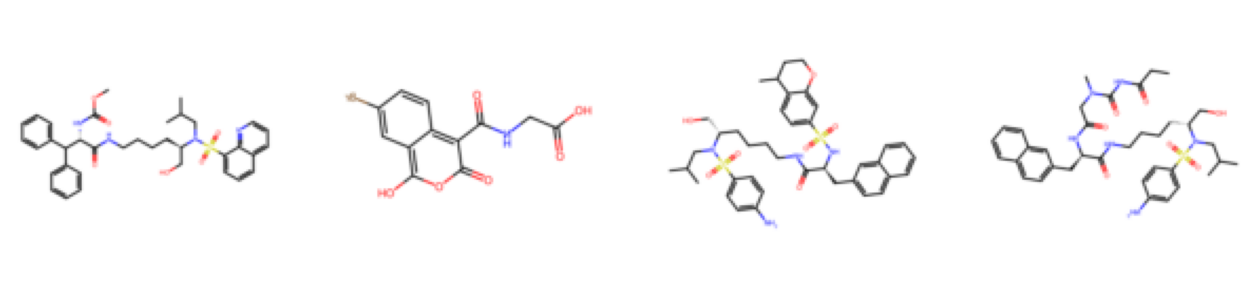

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(dataset[:4]["images"]):
    axs[i].imshow(image.permute(1, 2, 0).numpy() / 2 + 0.5)
    axs[i].set_axis_off()
fig.show()

In [ ]:
import torch

train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=config.train_batch_size, shuffle=True)

In [ ]:
from diffusers import UNet2DModel


model = UNet2DModel(
    sample_size=config.image_size,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(128, 128, 256, 256, 512, 512),  # the number of output channes for each UNet block
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D"
      ),
)

In [ ]:
sample_image = dataset[0]['images'].unsqueeze(0)
print('Input shape:', sample_image.shape)

Input shape: torch.Size([1, 3, 128, 128])


In [ ]:
print('Output shape:', model(sample_image, timestep=0).sample.shape)

Output shape: torch.Size([1, 3, 128, 128])


In [ ]:
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

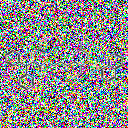

In [ ]:
import torch
from PIL import Image

noise = torch.randn(sample_image.shape)
timesteps = torch.LongTensor([50])
noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)

Image.fromarray(((noisy_image.permute(0, 2, 3, 1) + 1.0) * 127.5).type(torch.uint8).numpy()[0])

In [ ]:
import torch.nn.functional as F

noise_pred = model(noisy_image, timesteps).sample
loss = F.mse_loss(noise_pred, noise)

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)

In [ ]:
from diffusers.optimization import get_cosine_schedule_with_warmup

lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(train_dataloader) * config.num_epochs),
)

In [ ]:
from diffusers import DDPMPipeline

import math

def make_grid(images, rows, cols):
    w, h = images[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    for i, image in enumerate(images):
        grid.paste(image, box=(i%cols*w, i//cols*h))
    return grid

def evaluate(config, epoch, pipeline):
    # Sample some images from random noise (this is the backward diffusion process).
    # The default pipeline output type is `List[PIL.Image]`
    images = pipeline(
        batch_size = config.eval_batch_size,
        generator=torch.manual_seed(config.seed),
    ).images

    # Make a grid out of the images
    image_grid = make_grid(images, rows=4, cols=4)

    # Save the images
    test_dir = os.path.join(config.output_dir, "samples")
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f"{test_dir}/{epoch:04d}.png")

In [ ]:
from accelerate import Accelerator
from huggingface_hub import HfFolder, Repository, whoami

from tqdm.auto import tqdm
from pathlib import Path
import os

def get_full_repo_name(model_id: str, organization: str = None, token: str = None):
    if token is None:
        token = HfFolder.get_token()
    if organization is None:
        username = whoami(token)["name"]
        return f"{username}/{model_id}"
    else:
        return f"{organization}/{model_id}"

def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    # Initialize accelerator and tensorboard logging
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        log_with="tensorboard",
        project_dir=os.path.join(config.output_dir, "logs")
    )
    if accelerator.is_main_process:
        if config.push_to_hub:
            repo_name = get_full_repo_name(Path(config.output_dir).name)
            repo = Repository(config.output_dir, clone_from=repo_name)
        elif config.output_dir is not None:
            os.makedirs(config.output_dir, exist_ok=True)
        accelerator.init_trackers("train_example")

    # Prepare everything
    # There is no specific order to remember, you just need to unpack the
    # objects in the same order you gave them to the prepare method.
    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )

    global_step = 0

    # Now you train the model
    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(train_dataloader):
            clean_images = batch['images']
            # Sample noise to add to the images
            noise = torch.randn(clean_images.shape).to(clean_images.device)
            bs = clean_images.shape[0]

            # Sample a random timestep for each image
            timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (bs,), device=clean_images.device).long()

            # Add noise to the clean images according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

            with accelerator.accumulate(model):
                # Predict the noise residual
                noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
                loss = F.mse_loss(noise_pred, noise)
                accelerator.backward(loss)

                accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1

        # After each epoch you optionally sample some demo images with evaluate() and save the model
        if accelerator.is_main_process:
            pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)

            if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
                evaluate(config, epoch, pipeline)

            if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
                if config.push_to_hub:
                    repo.push_to_hub(commit_message=f"Epoch {epoch}", blocking=True)
                else:
                    pipeline.save_pretrained(config.output_dir)

In [ ]:
! pip install git+https://github.com/huggingface/accelerate


  Cloning https://github.com/huggingface/accelerate to /tmp/pip-req-build-_m2c8nrh
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/accelerate /tmp/pip-req-build-_m2c8nrh
  Resolved https://github.com/huggingface/accelerate to commit 11e2e99cfca3afe1cefe02111f40665b692b86fb
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for accelerate: filename=accelerate-0.24.0.dev0-py3-none-any.whl size=259482 sha256=f9c874b4678f20ffb76e6ac5ec684fd64da2d96febc41e305fe6f402ab5f8dc8
  Stored in directory: /tmp/pip-ephem-wheel-cache-yuij0n61/wheels/f6/c7/9d/1b8a5ca8353d9307733bc719107acb67acdc95063bba749f26
Successfully built accelerate
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.23.0
    Uninstalling accelerate-0.23.0:
      Successfully uninstalled accelerate-0.23.0


In [ ]:
from accelerate import notebook_launcher

In [ ]:

args = (config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)

notebook_launcher(train_loop, args, num_processes=1)

Launching training on one GPU.


Cloning https://huggingface.co/rebe121314/pharma_protease_test into local empty directory.


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Adding files tracked by Git LFS: ['samples/0009.png', 'samples/0019.png', 'samples/0029.png']. This may take a bit of time if the files are large.


Upload file samples/0019.png:   4%|4         | 32.0k/766k [00:00<?, ?B/s]

Upload file logs/train_example/events.out.tfevents.1698138444.6f03f92b952c.738.0: 100%|##########| 11.0k/11.0k…

Upload file samples/0009.png:   5%|4         | 32.0k/700k [00:00<?, ?B/s]

Upload file samples/0029.png:   5%|4         | 32.0k/706k [00:00<?, ?B/s]

To https://huggingface.co/rebe121314/pharma_protease_test
   5f6c9dd..f52ab29  main -> main

   5f6c9dd..f52ab29  main -> main



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Adding files tracked by Git LFS: ['samples/0039.png', 'samples/0049.png']. This may take a bit of time if the files are large.


Upload file samples/0039.png:   5%|5         | 32.0k/603k [00:00<?, ?B/s]

Upload file logs/train_example/events.out.tfevents.1698138444.6f03f92b952c.738.0: 100%|##########| 18.3k/18.3k…

Upload file samples/0049.png:   6%|5         | 32.0k/579k [00:00<?, ?B/s]

To https://huggingface.co/rebe121314/pharma_protease_test
   f52ab29..b1fc756  main -> main

   f52ab29..b1fc756  main -> main



Let's have a look at the final image grid produced by the trained diffusion model:

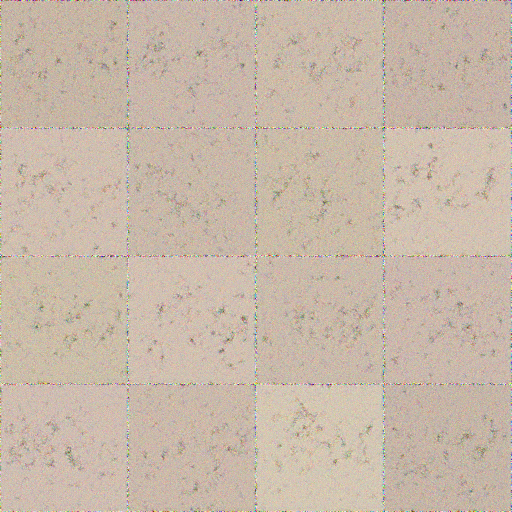

In [ ]:
import glob

sample_images = sorted(glob.glob(f"{config.output_dir}/samples/*.png"))
Image.open(sample_images[-1])